# Stochastic Optimization - Implementation project

Supervised by: Prof. Olivier FERCOQ

Done by: Iyad WALWIL

In this project, I'm implementing an ***Image Classifier*** where the aim is to classify digits between 0 and 9 using the stochastic approach we have learned during the class. 

### Basic Remarks
* I used the **MNIST** database available on their website http://yann.lecun.com/exdb/mnist/

        The MNIST database of handwritten numbers, contains a training set of 60,000 examples and a test set of 10,000 examples.
        
* We are in a case of **Supervised Learning**, we have the pictures as well as their labels.
* I used the **Multinomial logisitic regression with squared 2-norm regularization** model, where the objective function is the convex function:- 
$$F(w,w_0) = \frac{1}{n} \sum_{i = 1}^{n} \log~(\sum_{j = 0}^{9} \exp~(\sum_{k = 1}^{d} x_{i,k}w_{k,j} + w_{0_j})) - \sum_{j = 0}^{9} y_{i,j}(\sum_{k = 1}^{d} x_{i,k}w_{k,j} + w_{0_j}) + \frac{\alpha}{2} \|w\|^2_2$$
Where, 
1. $x_i$ is an image in the training dataset.
1. $n$ is the number of images in the training dataset.
2. $d$ is the number of pixels in the image $x_i$.
3. $\alpha \in \mathbb{R}^+$
4. $y_{i,j} = \begin{cases} 1 & \text{If the image} ~i~ \text{represents digit}~ j \\ 0 & \text{Otherwise}\end{cases}$

### Advantage of the Studied "Stochastic Algorithms"

Since the objective function to be minimized can be written as a finite sum
$$F(w,w_0) = \frac{1}{n} \sum_{i = 1}^{n} F_i(w,w_0)$$ 
Where, $~\forall i \in \{1,\dots \dots, n\}$
$$F_i(w,w_0) = \log~(\sum_{j = 0}^{9} \exp~(\sum_{k = 1}^{d} x_{i,k}w_{k,j} + w_{0_j})) - \sum_{j = 0}^{9} y_{i,j}(\sum_{k = 1}^{d} x_{i,k}w_{k,j} + w_{0_j}) + \frac{\alpha}{2} \|w\|^2_2$$

Then, from what we can observe in all the studied stochastic algorithms (stochastic gradient, SVRG, Adagrad and ADAM) that at each iteration we actually need just the gradient of $F_i$ respect to $w ~\& ~ w_0$ for some **radnom** $i$ instead of the gradient of $F$.

### Gradients Computation 
$\forall i \in \{1, \dots \dots, n\}$
1. The gradient of $F_i$ respect to $w_{t,p} ~ \forall t \in \{1, \dots \dots, d\} ~ \& ~ \forall p \in \{0, \dots \dots, 9\}$  
$$\nabla_{w_{t, p}} F_i = x_{i,t}\frac{\exp~(\sum_{k = 1}^{d} x_{i,k}w_{k,p} + w_{0_p})}{\sum_{j = 0}^{9} \exp~(\sum_{k = 1}^{d} x_{i,k}w_{k,j} + w_{0_j})} - y_{i,p}x_{i,t} + w_{t, p}$$
2. The gradient of $F_i$ respect to $w_{0_p} ~ \forall p \in \{0, \dots \dots, 9\}$  
$$\nabla_{w_{0_p}} F_i = \frac{\exp~(\sum_{k = 1}^{d} x_{i,k}w_{k,p} + w_{0_p})}{\sum_{j = 0}^{9} \exp~(\sum_{k = 1}^{d} x_{i,k}w_{k,j} + w_{0_j})} - y_{i,p}$$

***Importing all the needed libraries***

In [3]:
import numpy as np
import random
import idx2numpy
import matplotlib.pyplot as plt

***Reading the training dataset images***

In [4]:
training_images = 'data/train-images.idx3-ubyte'
X = idx2numpy.convert_from_file(training_images)

***Reading the training dataset labels***

In [5]:
tranining_labels = 'data/train-labels.idx1-ubyte'
Y_hat = idx2numpy.convert_from_file(tranining_labels)

***Parameters***

In [31]:
n = np.shape(X[1])        # The dimesnion of any image in the training dataset   (28 x 28)
J = 10                    # Number of digits between 0 and 9   (10)
N = len(X)                # Number of images in the traning dataset (60,000)
N_ite = 20000             # Number of iterations for the algorithm 

***Example***
Checking that the image and the label are coincide 

The label of the image:  0
The image: 


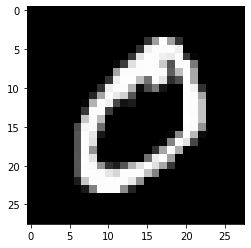

In [8]:
print("The label of the image: ", Y_hat[1])
print("The image: ")
plt.imshow(X[1], cmap='gray')

***Defining the matrix*** $y_{i,j}$ ***considered in the "Basic Remarks" section***
$$y_{i,j} = \begin{cases} 1 & \text{If the image} ~i~ \text{represents digit}~ j \\ 0 & \text{Otherwise}\end{cases}$$

In [7]:
Y = np.zeros((N,J))
for s in range(N):
    Y[s][Y_hat[s]] = 1

### keeping part of the training set into a validation set
I have kept the last 5000 images of the training dataset into a validation dataset along with their labels

In [9]:
X_valid = X[-5000:]             # The validation dataset images
Y_valid = Y_hat[-5000:]         # The validation dataset lables
N_valid = len(X_valid)          # Number of images in the validation dataset (5000)

### Implementing the Gradient of $F_i$
From the above computations, we know that 
$\forall i \in \{1, \dots \dots, n\}$
1. The gradient of $F_i$ respect to $w_{t,p} ~ \forall t \in \{1, \dots \dots, d\} ~ \& ~ \forall p \in \{0, \dots \dots, 9\}$  
$$\nabla_{w_{t, p}} F_i = x_{i,t}\frac{\exp~(\sum_{k = 1}^{d} x_{i,k}w_{k,p} + w_{0_p})}{\sum_{j = 0}^{9} \exp~(\sum_{k = 1}^{d} x_{i,k}w_{k,j} + w_{0_j})} - y_{i,p}x_{i,t} + w_{t, p}$$
2. The gradient of $F_i$ respect to $w_{0_p} ~ \forall p \in \{0, \dots \dots, 9\}$  
$$\nabla_{w_{0_p}} F_i = \frac{\exp~(\sum_{k = 1}^{d} x_{i,k}w_{k,p} + w_{0_p})}{\sum_{j = 0}^{9} \exp~(\sum_{k = 1}^{d} x_{i,k}w_{k,j} + w_{0_j})} - y_{i,p}$$

***For Simplicity***

Let:-
* $D = \sum_{j = 0}^{9} \exp~(\sum_{k = 1}^{d} x_{i,k}w_{k,j} + w_{0_j})$
* $E_j = \exp~(\sum_{k = 1}^{d} x_{i,k}w_{k,p} + w_{0_p}) ~~~~~ \forall j \in \{0, \dots \dots, 9\}$

***Then,***

$\forall i \in \{1, \dots \dots, n\}$
1. The gradient of $F_i$ respect to $w_{t,p} ~ \forall t \in \{1, \dots \dots, d\} ~ \& ~ \forall p \in \{0, \dots \dots, 9\}$  
$$\nabla_{w_{t, p}} F_i = x_{i,t}\frac{E_p}{D} - y_{i,p}x_{i,t} + w_{t, p}$$
2. The gradient of $F_i$ respect to $w_{0_p} ~ \forall p \in \{0, \dots \dots, 9\}$  
$$\nabla_{w_{0_p}} F_i = \frac{E_p}{D} - y_{i,p}$$

In [32]:
def gradient_Denominator(m, W, W0):      # m represents the index of the image X (X[m]), hence the gradient of F_m
                                                # for all m = 1,.......,60000
    
    D = 0                     
    E = np.zeros(J)       # 1-dimensional array with 10 elements 
    for j in range(J):
        E[j] = np.exp(W0[j] + np.vdot(X[m], W[:,:,j]))       # Computing E_p for each p = 0,....,9
        D += E[j]                                            # Computing the denominator of the gradient 
    
    return E, D

# -------------------------------------------------------------------------------------------------------------------------

def gradient_F_i(m, W, W0, alpha):
    
    G_W = np.zeros((n[0], n[1],J))                       # The gradient of F_i w.r.t. w (3-dimensional array) 
    G_W0 = np.zeros(J)                                   # The gradient of F_i w.r.t. w_0 (1-dimensional array)
    
    E, D = gradient_Denominator(m, W, W0)               # Computing D and E_j explained above
    for j in range(J):
        G_W[:,:, j] = X[m]*(E[j]/D) - Y[m][j]*X[m] + alpha*W[:,:,j]   # Computing the gradient w.r.t. w
        G_W0[j] = E[j]/D - Y[m][j]                                    # Computing the gradient w.r.t. w_0
    
    return (G_W, G_W0)          # returning the value of the gradient w.r.t. w & w_0 

### Stochastic Gradient Algorithm 
* First of all, let us ***recall the stochastic gradient algorithm***:-
***
Given a sequence of step sizes $\gamma_k$, and $x_0 \in \mathbb{R}^d$, the algorithm reads:- 
$$x_{k+1} = x_k - \gamma_k \nabla f(x_k, \xi_{k+1})$$
***
**Thus,** in our case:- 
$$(w_{k+1}, w_{0_{k+1}}) = (w_{k}, w_{0_{k}}) - \gamma_k (\nabla_{w} F_i(w_k,w_{0_k}), \nabla_{w_0} F_i(w_k,w_{0_k}))$$

* Since $F$ is convex, we can benefit of the step size sequences studied during the course, we have two cases:- 
\begin{cases}
\gamma_k = \frac{\gamma_0}{\sqrt{k + 1}} & \text{If the number of iterations is unknown} \\ 
\gamma_k = \frac{a}{\sqrt{K}} & \text{If the number of iterations} = K
\end{cases}

* I tried to implement the algotithm using the norm 2 as a stopping criterion with non-constant step size, namely $\gamma_k = \frac{\gamma_0}{\sqrt{k + 1}}$
    However, for some error I wasn't able to figure it out, it didn't yield a good accuracy 
* In contract, by determining a specific number of iterations just before running the algorithm and thus with a constant step size, namely, $\gamma_k = \frac{a}{\sqrt{K}}$ where $K$ is the number of iterations, the algorithm has yielded a very good accuracy!

#### Stochastic Gradient Algorithm with Norm 2 as a Stopping Criterion

In [45]:
def stochastic_Gradient_norm_2(alpha = 0.4, W_init = np.zeros((n[0], n[1], J)), W0_init = np.zeros(J),  
             gamma0 = 2e-5, eps = 2e-8, fun = gradient_F_i):    

    
    k = 0                               # Initial iteration 
    gamma = gamma0
    W_hat, W0_hat = W_init, W0_init
    
    # Makeing one iteration of the algorithm 
    m = random.randint(0, N-1)
    G_F_i = fun(m, W_hat, W0_hat, alpha)
    W, W0  = W_hat - gamma*G_F_i[0], W0_hat - gamma*G_F_i[1]
    
    k +=1
    
    # Computing the norm 2
    dist = np.sqrt(np.linalg.norm(W_hat - W)**2 + np.linalg.norm(W0_hat - W0)**2)
    
    # Checking Condition 
    while (dist > eps):
        
        # Algorithm steps 
        m = random.randint(0, N-1)            # The randomness 
        gamma = gamma/np.sqrt(k+1)            # The step size update 
        G_F_i = fun(m, W, W0, alpha)          # The gradient of F_i w.r.t. both w and w_0 
        temp1,temp2 = W - gamma*G_F_i[0], W0 - gamma*G_F_i[1]   # The w and w_0 Update 
        
        W_hat, W0_hat = W, W0
        W, W0 = temp1, temp2
        
        k +=1
        dist = np.sqrt(np.linalg.norm(W_hat - W)**2 + np.linalg.norm(W0_hat - W0)**2)
        
    return W, W0, dist, k

#### Stochastic Gradient Algorithm with a Fixed Number of Iterations

In [15]:
def stochastic_Gradient(alpha = 0.4, W = np.zeros((n[0], n[1], J)), W0 = np.zeros(J),  
             gamma = 1e-3/np.sqrt(N_ite), K = N_ite, fun = gradient_F_i): 
    
    for k in range(K):
        m = random.randint(0, N-1)         # The randomness 
        G_F_i = fun(m, W, W0, alpha)       # The gradient of F_i w.r.t. both w and w_0
        W = W - gamma*G_F_i[0]             # The w Update
        W0 = W0 - gamma*G_F_i[1]           # The w_0 Update 

    return W

### Defining the Accuracy Function

$$L(w) = \frac{1}{n_{valid}} \sum_{j = 1}^{n_{valid}} \ell(x_i^{valid}w, y_i^{valid})$$
Where, 

$\ell(x_i^{valid}w, y_i^{valid}) = \begin{cases} 1 & \text{if the largest value of the 10-dimensional vector} ~ x_i^{valid}w ~ \text{is for the good digit} \\ 0 & \text{Otherwise} \end{cases}$

***Recall that***
1. $X_{valid} = X[-5000:]~~$             The validation dataset images
2. $Y_{valid} = Y_hat[-5000:]~~$ The validation dataset lables
3. $N_{valid} = len(X_{valid})~~$ Number of images in the validation dataset (5000)

In [41]:
def valid_Accuracy(W):
    
    n = N - N_valid          # As N = 60,000 and N_valid = 5,000, I defined n = N - N_valid so we can 
                            # choose a random number between 55,000 and 60,000 which is the range of the validation dataset
    max_index = 0     
    S = 0
    
    for i in range(n, N):
        L = []
        for j in range(J):
            L.append(np.vdot(X_valid[i - n], W[:,:, j]))
        max_L = max(L)                                   # Finding the max. accuracy obtained 
        max_index = L.index(max_L)                       # Finding the INDEX of the max. accuracy abtained     
        if (max_index == Y_valid[i - n]):                # Checking if the max._index is for the good digit
            S += 1
            
    return (S/N_valid)                                   # returning the accuracy 

***Example on the stochastic gradient algorithm with norm 2 as a stopping criterion*** 

Checking out the algorithm performance

In [46]:
W_amin, W0_amin, di, it = stochastic_Gradient_norm_2()
print(it)

17


In [47]:
acc = valid_Accuracy(W_amin)
print(acc)

0.1708


The above result is kind of weird. Unfortunately, as I said, I wasn't able to figure out the problem 

***Example on the stochastic gradient algorithm with a fixed number of iterations*** 

Checking out the algorithm performance

In [48]:
W_amin = stochastic_Gradient()

In [49]:
Acc = valid_Accuracy(W_amin)
print(Acc)

0.879


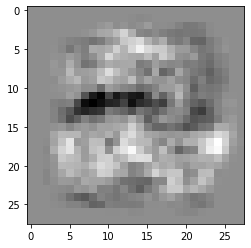

In [50]:
plt.imshow(W_amin[:,:,2], cmap='gray')

The above computations show a very good results. Therefore, I've relied the ***stochastic algorithm with a fixed number of iterations*** for the rest of the code

### Running the Algorithm for 4000 valus of $\alpha$

* I've defined a set of 4000 values for $\alpha$ between $0.001 ~\& ~ 3$ and tried the ***stochastic algorithm with a fixed number of iterations*** on it 

* It yielded a best accuracy about 90% that I think it's pretty good.

**Note:** I've defined a function computing the best $\alpha$ afterwards instead of repeating the code, but for this one, it was painful to re-run it using the function, so I kept it

In [27]:
A = np.linspace(0.001, 3, 4000)        # Set of possible alphas 
L_acc = []                             # List of the accuracy for each alpha 
for alpha in A:
    print("alpha = ", alpha)
    W_hat = stochastic_Gradient(alpha)   # Using the stochastic gradient to find w
    acc = valid_Accuracy(W_hat)          # Computing the accuracy for the founded w
    print("Acceracy = ", acc)
    L_acc.append(acc)                    # Adding the accuracy to the list 

alpha =  0.001
Acceracy =  0.887
alpha =  0.0017499374843710927
Acceracy =  0.891
alpha =  0.0024998749687421854
Acceracy =  0.8756
alpha =  0.0032498124531132786
Acceracy =  0.871
alpha =  0.003999749937484372
Acceracy =  0.8758
alpha =  0.0047496874218554645
Acceracy =  0.8778
alpha =  0.005499624906226557
Acceracy =  0.8396
alpha =  0.00624956239059765
Acceracy =  0.887
alpha =  0.006999499874968743
Acceracy =  0.8282
alpha =  0.007749437359339835
Acceracy =  0.8638
alpha =  0.008499374843710928
Acceracy =  0.8578
alpha =  0.009249312328082022
Acceracy =  0.8552
alpha =  0.009999249812453113
Acceracy =  0.874
alpha =  0.010749187296824208
Acceracy =  0.8804
alpha =  0.011499124781195299
Acceracy =  0.8188
alpha =  0.012249062265566393
Acceracy =  0.8754
alpha =  0.012998999749937484
Acceracy =  0.8452
alpha =  0.013748937234308579
Acceracy =  0.888
alpha =  0.01449887471867967
Acceracy =  0.8524
alpha =  0.015248812203050764
Acceracy =  0.8268
alpha =  0.015998749687421855
Acceracy 

Acceracy =  0.8964
alpha =  0.12998924731182795
Acceracy =  0.864
alpha =  0.13073918479619906
Acceracy =  0.8614
alpha =  0.13148912228057016
Acceracy =  0.8864
alpha =  0.13223905976494124
Acceracy =  0.8838
alpha =  0.13298899724931235
Acceracy =  0.8816
alpha =  0.13373893473368342
Acceracy =  0.8612
alpha =  0.13448887221805453
Acceracy =  0.8572
alpha =  0.1352388097024256
Acceracy =  0.8594
alpha =  0.1359887471867967
Acceracy =  0.8938
alpha =  0.13673868467116781
Acceracy =  0.8668
alpha =  0.1374886221555389
Acceracy =  0.87
alpha =  0.13823855963991
Acceracy =  0.858
alpha =  0.13898849712428107
Acceracy =  0.8682
alpha =  0.13973843460865218
Acceracy =  0.8598
alpha =  0.14048837209302326
Acceracy =  0.8888
alpha =  0.14123830957739436
Acceracy =  0.833
alpha =  0.14198824706176544
Acceracy =  0.88
alpha =  0.14273818454613654
Acceracy =  0.8736
alpha =  0.14348812203050765
Acceracy =  0.8708
alpha =  0.14423805951487872
Acceracy =  0.8594
alpha =  0.14498799699924983
Accer

Acceracy =  0.8642
alpha =  0.25972843210802704
Acceracy =  0.8556
alpha =  0.2604783695923981
Acceracy =  0.8288
alpha =  0.2612283070767692
Acceracy =  0.8822
alpha =  0.2619782445611403
Acceracy =  0.8892
alpha =  0.2627281820455114
Acceracy =  0.871
alpha =  0.2634781195298825
Acceracy =  0.8974
alpha =  0.26422805701425356
Acceracy =  0.906
alpha =  0.2649779944986247
Acceracy =  0.8378
alpha =  0.26572793198299577
Acceracy =  0.8834
alpha =  0.26647786946736685
Acceracy =  0.8602
alpha =  0.267227806951738
Acceracy =  0.8832
alpha =  0.26797774443610906
Acceracy =  0.8736
alpha =  0.26872768192048013
Acceracy =  0.8532
alpha =  0.2694776194048512
Acceracy =  0.8638
alpha =  0.27022755688922234
Acceracy =  0.8324
alpha =  0.2709774943735934
Acceracy =  0.9016
alpha =  0.2717274318579645
Acceracy =  0.8658
alpha =  0.27247736934233563
Acceracy =  0.887
alpha =  0.2732273068267067
Acceracy =  0.8998
alpha =  0.2739772443110778
Acceracy =  0.8832
alpha =  0.27472718179544886
Acceracy

Acceracy =  0.8128
alpha =  0.3902175543885972
Acceracy =  0.8642
alpha =  0.39096749187296825
Acceracy =  0.8726
alpha =  0.3917174293573394
Acceracy =  0.856
alpha =  0.39246736684171046
Acceracy =  0.8808
alpha =  0.39321730432608154
Acceracy =  0.8816
alpha =  0.3939672418104526
Acceracy =  0.8854
alpha =  0.39471717929482375
Acceracy =  0.8994
alpha =  0.3954671167791948
Acceracy =  0.8788
alpha =  0.3962170542635659
Acceracy =  0.882
alpha =  0.39696699174793704
Acceracy =  0.8538
alpha =  0.3977169292323081
Acceracy =  0.869
alpha =  0.3984668667166792
Acceracy =  0.875
alpha =  0.39921680420105027
Acceracy =  0.867
alpha =  0.3999667416854214
Acceracy =  0.8712
alpha =  0.4007166791697925
Acceracy =  0.8798
alpha =  0.40146661665416356
Acceracy =  0.8446
alpha =  0.4022165541385347
Acceracy =  0.8804
alpha =  0.40296649162290576
Acceracy =  0.8908
alpha =  0.40371642910727684
Acceracy =  0.8574
alpha =  0.4044663665916479
Acceracy =  0.8828
alpha =  0.40521630407601905
Acceracy

Acceracy =  0.885
alpha =  0.5214566141535384
Acceracy =  0.8892
alpha =  0.5222065516379095
Acceracy =  0.8674
alpha =  0.5229564891222807
Acceracy =  0.8674
alpha =  0.5237064266066517
Acceracy =  0.8788
alpha =  0.5244563640910228
Acceracy =  0.896
alpha =  0.5252063015753938
Acceracy =  0.8534
alpha =  0.525956239059765
Acceracy =  0.8892
alpha =  0.5267061765441361
Acceracy =  0.8608
alpha =  0.5274561140285071
Acceracy =  0.8836
alpha =  0.5282060515128782
Acceracy =  0.8686
alpha =  0.5289559889972494
Acceracy =  0.8654
alpha =  0.5297059264816204
Acceracy =  0.8784
alpha =  0.5304558639659915
Acceracy =  0.8868
alpha =  0.5312058014503627
Acceracy =  0.8822
alpha =  0.5319557389347337
Acceracy =  0.8424
alpha =  0.5327056764191048
Acceracy =  0.8738
alpha =  0.533455613903476
Acceracy =  0.8362
alpha =  0.534205551387847
Acceracy =  0.8702
alpha =  0.5349554888722181
Acceracy =  0.8934
alpha =  0.5357054263565891
Acceracy =  0.889
alpha =  0.5364553638409603
Acceracy =  0.848
a

Acceracy =  0.8732
alpha =  0.6534456114028507
Acceracy =  0.8698
alpha =  0.6541955488872219
Acceracy =  0.8578
alpha =  0.6549454863715929
Acceracy =  0.8438
alpha =  0.655695423855964
Acceracy =  0.8916
alpha =  0.6564453613403352
Acceracy =  0.8406
alpha =  0.6571952988247062
Acceracy =  0.8572
alpha =  0.6579452363090773
Acceracy =  0.8606
alpha =  0.6586951737934484
Acceracy =  0.8516
alpha =  0.6594451112778195
Acceracy =  0.8718
alpha =  0.6601950487621906
Acceracy =  0.8518
alpha =  0.6609449862465617
Acceracy =  0.8984
alpha =  0.6616949237309327
Acceracy =  0.874
alpha =  0.6624448612153039
Acceracy =  0.8252
alpha =  0.663194798699675
Acceracy =  0.8486
alpha =  0.663944736184046
Acceracy =  0.8366
alpha =  0.6646946736684172
Acceracy =  0.815
alpha =  0.6654446111527882
Acceracy =  0.8796
alpha =  0.6661945486371593
Acceracy =  0.8594
alpha =  0.6669444861215305
Acceracy =  0.823
alpha =  0.6676944236059015
Acceracy =  0.8456
alpha =  0.6684443610902726
Acceracy =  0.8646


Acceracy =  0.8138
alpha =  0.7854346086521631
Acceracy =  0.8486
alpha =  0.7861845461365342
Acceracy =  0.9022
alpha =  0.7869344836209052
Acceracy =  0.8876
alpha =  0.7876844211052764
Acceracy =  0.8564
alpha =  0.7884343585896475
Acceracy =  0.8352
alpha =  0.7891842960740185
Acceracy =  0.8666
alpha =  0.7899342335583897
Acceracy =  0.8162
alpha =  0.7906841710427608
Acceracy =  0.8402
alpha =  0.7914341085271318
Acceracy =  0.868
alpha =  0.7921840460115029
Acceracy =  0.8124
alpha =  0.7929339834958741
Acceracy =  0.8334
alpha =  0.7936839209802451
Acceracy =  0.8292
alpha =  0.7944338584646162
Acceracy =  0.8642
alpha =  0.7951837959489872
Acceracy =  0.8744
alpha =  0.7959337334333584
Acceracy =  0.8794
alpha =  0.7966836709177295
Acceracy =  0.8582
alpha =  0.7974336084021005
Acceracy =  0.9038
alpha =  0.7981835458864717
Acceracy =  0.8608
alpha =  0.7989334833708428
Acceracy =  0.8952
alpha =  0.7996834208552138
Acceracy =  0.8612
alpha =  0.800433358339585
Acceracy =  0.8

Acceracy =  0.8328
alpha =  0.9174236059014754
Acceracy =  0.85
alpha =  0.9181735433858466
Acceracy =  0.8604
alpha =  0.9189234808702176
Acceracy =  0.8834
alpha =  0.9196734183545887
Acceracy =  0.7828
alpha =  0.9204233558389598
Acceracy =  0.8746
alpha =  0.9211732933233309
Acceracy =  0.8416
alpha =  0.921923230807702
Acceracy =  0.8634
alpha =  0.9226731682920731
Acceracy =  0.894
alpha =  0.9234231057764442
Acceracy =  0.8922
alpha =  0.9241730432608153
Acceracy =  0.8334
alpha =  0.9249229807451863
Acceracy =  0.8774
alpha =  0.9256729182295574
Acceracy =  0.868
alpha =  0.9264228557139286
Acceracy =  0.8636
alpha =  0.9271727931982996
Acceracy =  0.8928
alpha =  0.9279227306826707
Acceracy =  0.879
alpha =  0.9286726681670419
Acceracy =  0.858
alpha =  0.9294226056514129
Acceracy =  0.8854
alpha =  0.930172543135784
Acceracy =  0.858
alpha =  0.9309224806201551
Acceracy =  0.8898
alpha =  0.9316724181045262
Acceracy =  0.864
alpha =  0.9324223555888973
Acceracy =  0.8736
alph

Acceracy =  0.8818
alpha =  1.0494126031507875
Acceracy =  0.8766
alpha =  1.0501625406351587
Acceracy =  0.8592
alpha =  1.0509124781195298
Acceracy =  0.8288
alpha =  1.051662415603901
Acceracy =  0.809
alpha =  1.052412353088272
Acceracy =  0.8378
alpha =  1.0531622905726432
Acceracy =  0.8328
alpha =  1.0539122280570141
Acceracy =  0.8758
alpha =  1.0546621655413853
Acceracy =  0.842
alpha =  1.0554121030257564
Acceracy =  0.871
alpha =  1.0561620405101275
Acceracy =  0.8792
alpha =  1.0569119779944987
Acceracy =  0.8068
alpha =  1.0576619154788698
Acceracy =  0.8744
alpha =  1.0584118529632407
Acceracy =  0.8856
alpha =  1.0591617904476118
Acceracy =  0.8862
alpha =  1.059911727931983
Acceracy =  0.8666
alpha =  1.060661665416354
Acceracy =  0.8806
alpha =  1.0614116029007252
Acceracy =  0.8878
alpha =  1.0621615403850961
Acceracy =  0.8846
alpha =  1.0629114778694673
Acceracy =  0.8908
alpha =  1.0636614153538384
Acceracy =  0.8586
alpha =  1.0644113528382095
Acceracy =  0.8578
a

Acceracy =  0.853
alpha =  1.1814016004001
Acceracy =  0.8896
alpha =  1.1821515378844711
Acceracy =  0.8156
alpha =  1.1829014753688423
Acceracy =  0.8756
alpha =  1.1836514128532132
Acceracy =  0.8318
alpha =  1.1844013503375843
Acceracy =  0.8292
alpha =  1.1851512878219554
Acceracy =  0.8818
alpha =  1.1859012253063266
Acceracy =  0.8678
alpha =  1.1866511627906977
Acceracy =  0.8884
alpha =  1.1874011002750688
Acceracy =  0.8636
alpha =  1.1881510377594398
Acceracy =  0.8754
alpha =  1.1889009752438109
Acceracy =  0.892
alpha =  1.189650912728182
Acceracy =  0.8492
alpha =  1.1904008502125532
Acceracy =  0.8908
alpha =  1.1911507876969243
Acceracy =  0.8806
alpha =  1.1919007251812952
Acceracy =  0.8662
alpha =  1.1926506626656663
Acceracy =  0.8476
alpha =  1.1934006001500375
Acceracy =  0.7988
alpha =  1.1941505376344086
Acceracy =  0.8676
alpha =  1.1949004751187797
Acceracy =  0.9066
alpha =  1.1956504126031509
Acceracy =  0.873
alpha =  1.1964003500875218
Acceracy =  0.88
alp

Acceracy =  0.8724
alpha =  1.3141405351337834
Acceracy =  0.8348
alpha =  1.3148904726181545
Acceracy =  0.8758
alpha =  1.3156404101025256
Acceracy =  0.882
alpha =  1.3163903475868968
Acceracy =  0.8754
alpha =  1.317140285071268
Acceracy =  0.8378
alpha =  1.3178902225556388
Acceracy =  0.8696
alpha =  1.31864016004001
Acceracy =  0.8832
alpha =  1.319390097524381
Acceracy =  0.8834
alpha =  1.3201400350087522
Acceracy =  0.8616
alpha =  1.3208899724931233
Acceracy =  0.8724
alpha =  1.3216399099774943
Acceracy =  0.8834
alpha =  1.3223898474618654
Acceracy =  0.8726
alpha =  1.3231397849462365
Acceracy =  0.8352
alpha =  1.3238897224306077
Acceracy =  0.8482
alpha =  1.3246396599149788
Acceracy =  0.8854
alpha =  1.32538959739935
Acceracy =  0.8746
alpha =  1.3261395348837208
Acceracy =  0.878
alpha =  1.326889472368092
Acceracy =  0.849
alpha =  1.327639409852463
Acceracy =  0.854
alpha =  1.3283893473368342
Acceracy =  0.8808
alpha =  1.3291392848212054
Acceracy =  0.8496
alpha 

Acceracy =  0.8782
alpha =  1.446879469867467
Acceracy =  0.8478
alpha =  1.4476294073518379
Acceracy =  0.8438
alpha =  1.448379344836209
Acceracy =  0.9018
alpha =  1.4491292823205801
Acceracy =  0.875
alpha =  1.4498792198049513
Acceracy =  0.9056
alpha =  1.4506291572893224
Acceracy =  0.8772
alpha =  1.4513790947736933
Acceracy =  0.8632
alpha =  1.4521290322580644
Acceracy =  0.8804
alpha =  1.4528789697424356
Acceracy =  0.8836
alpha =  1.4536289072268067
Acceracy =  0.8942
alpha =  1.4543788447111778
Acceracy =  0.8342
alpha =  1.455128782195549
Acceracy =  0.8528
alpha =  1.4558787196799199
Acceracy =  0.8426
alpha =  1.456628657164291
Acceracy =  0.8576
alpha =  1.4573785946486622
Acceracy =  0.8528
alpha =  1.4581285321330333
Acceracy =  0.8708
alpha =  1.4588784696174044
Acceracy =  0.8856
alpha =  1.4596284071017753
Acceracy =  0.8398
alpha =  1.4603783445861465
Acceracy =  0.8302
alpha =  1.4611282820705176
Acceracy =  0.8382
alpha =  1.4618782195548887
Acceracy =  0.8772

Acceracy =  0.8884
alpha =  1.5796184046011503
Acceracy =  0.8658
alpha =  1.5803683420855215
Acceracy =  0.887
alpha =  1.5811182795698924
Acceracy =  0.869
alpha =  1.5818682170542635
Acceracy =  0.8268
alpha =  1.5826181545386346
Acceracy =  0.8442
alpha =  1.5833680920230058
Acceracy =  0.875
alpha =  1.584118029507377
Acceracy =  0.8656
alpha =  1.584867966991748
Acceracy =  0.8116
alpha =  1.585617904476119
Acceracy =  0.8802
alpha =  1.58636784196049
Acceracy =  0.8854
alpha =  1.5871177794448612
Acceracy =  0.8532
alpha =  1.5878677169292323
Acceracy =  0.8562
alpha =  1.5886176544136035
Acceracy =  0.8612
alpha =  1.5893675918979744
Acceracy =  0.8632
alpha =  1.5901175293823455
Acceracy =  0.8836
alpha =  1.5908674668667167
Acceracy =  0.853
alpha =  1.5916174043510878
Acceracy =  0.8406
alpha =  1.592367341835459
Acceracy =  0.8898
alpha =  1.59311727931983
Acceracy =  0.871
alpha =  1.593867216804201
Acceracy =  0.8434
alpha =  1.594617154288572
Acceracy =  0.8516
alpha =  

Acceracy =  0.8678
alpha =  1.7123573393348337
Acceracy =  0.8778
alpha =  1.7131072768192048
Acceracy =  0.8974
alpha =  1.713857214303576
Acceracy =  0.8738
alpha =  1.714607151787947
Acceracy =  0.885
alpha =  1.715357089272318
Acceracy =  0.8852
alpha =  1.7161070267566891
Acceracy =  0.8688
alpha =  1.7168569642410603
Acceracy =  0.8842
alpha =  1.7176069017254314
Acceracy =  0.8376
alpha =  1.7183568392098025
Acceracy =  0.8972
alpha =  1.7191067766941734
Acceracy =  0.8932
alpha =  1.7198567141785446
Acceracy =  0.8986
alpha =  1.7206066516629157
Acceracy =  0.8534
alpha =  1.7213565891472868
Acceracy =  0.8848
alpha =  1.722106526631658
Acceracy =  0.8964
alpha =  1.722856464116029
Acceracy =  0.8508
alpha =  1.7236064016004
Acceracy =  0.8164
alpha =  1.7243563390847712
Acceracy =  0.8692
alpha =  1.7251062765691423
Acceracy =  0.8678
alpha =  1.7258562140535134
Acceracy =  0.8888
alpha =  1.7266061515378845
Acceracy =  0.8962
alpha =  1.7273560890222555
Acceracy =  0.8916
alp

Acceracy =  0.8722
alpha =  1.8443463365841462
Acceracy =  0.856
alpha =  1.845096274068517
Acceracy =  0.8982
alpha =  1.8458462115528882
Acceracy =  0.8686
alpha =  1.8465961490372593
Acceracy =  0.8716
alpha =  1.8473460865216305
Acceracy =  0.7964
alpha =  1.8480960240060016
Acceracy =  0.8868
alpha =  1.8488459614903725
Acceracy =  0.8684
alpha =  1.8495958989747436
Acceracy =  0.8504
alpha =  1.8503458364591148
Acceracy =  0.8324
alpha =  1.851095773943486
Acceracy =  0.884
alpha =  1.851845711427857
Acceracy =  0.8834
alpha =  1.8525956489122282
Acceracy =  0.8512
alpha =  1.853345586396599
Acceracy =  0.8746
alpha =  1.8540955238809702
Acceracy =  0.8806
alpha =  1.8548454613653413
Acceracy =  0.8698
alpha =  1.8555953988497125
Acceracy =  0.8332
alpha =  1.8563453363340836
Acceracy =  0.7884
alpha =  1.8570952738184545
Acceracy =  0.8546
alpha =  1.8578452113028256
Acceracy =  0.8284
alpha =  1.8585951487871968
Acceracy =  0.8408
alpha =  1.859345086271568
Acceracy =  0.8148
a

Acceracy =  0.8816
alpha =  1.9770852713178295
Acceracy =  0.888
alpha =  1.9778352088022007
Acceracy =  0.8664
alpha =  1.9785851462865716
Acceracy =  0.8486
alpha =  1.9793350837709427
Acceracy =  0.886
alpha =  1.9800850212553138
Acceracy =  0.8308
alpha =  1.980834958739685
Acceracy =  0.8556
alpha =  1.981584896224056
Acceracy =  0.8376
alpha =  1.9823348337084272
Acceracy =  0.875
alpha =  1.9830847711927981
Acceracy =  0.8736
alpha =  1.9838347086771693
Acceracy =  0.8554
alpha =  1.9845846461615404
Acceracy =  0.8596
alpha =  1.9853345836459115
Acceracy =  0.848
alpha =  1.9860845211302827
Acceracy =  0.8668
alpha =  1.9868344586146536
Acceracy =  0.8734
alpha =  1.9875843960990247
Acceracy =  0.8744
alpha =  1.9883343335833958
Acceracy =  0.8358
alpha =  1.989084271067767
Acceracy =  0.85
alpha =  1.989834208552138
Acceracy =  0.8662
alpha =  1.9905841460365092
Acceracy =  0.8616
alpha =  1.9913340835208801
Acceracy =  0.8846
alpha =  1.9920840210052513
Acceracy =  0.8798
alph

Acceracy =  0.8632
alpha =  2.109824206051513
Acceracy =  0.8674
alpha =  2.110574143535884
Acceracy =  0.8784
alpha =  2.111324081020255
Acceracy =  0.8894
alpha =  2.112074018504626
Acceracy =  0.8646
alpha =  2.1128239559889974
Acceracy =  0.8342
alpha =  2.1135738934733683
Acceracy =  0.8918
alpha =  2.1143238309577397
Acceracy =  0.8856
alpha =  2.1150737684421106
Acceracy =  0.8246
alpha =  2.1158237059264815
Acceracy =  0.8736
alpha =  2.116573643410853
Acceracy =  0.8518
alpha =  2.1173235808952238
Acceracy =  0.8516
alpha =  2.118073518379595
Acceracy =  0.86
alpha =  2.118823455863966
Acceracy =  0.8706
alpha =  2.119573393348337
Acceracy =  0.8726
alpha =  2.1203233308327083
Acceracy =  0.8732
alpha =  2.121073268317079
Acceracy =  0.8698
alpha =  2.1218232058014506
Acceracy =  0.837
alpha =  2.1225731432858215
Acceracy =  0.8936
alpha =  2.1233230807701924
Acceracy =  0.8736
alpha =  2.1240730182545637
Acceracy =  0.8718
alpha =  2.1248229557389346
Acceracy =  0.87
alpha = 

Acceracy =  0.839
alpha =  2.2433130782695674
Acceracy =  0.872
alpha =  2.2440630157539387
Acceracy =  0.8722
alpha =  2.2448129532383096
Acceracy =  0.866
alpha =  2.2455628907226806
Acceracy =  0.8718
alpha =  2.246312828207052
Acceracy =  0.8546
alpha =  2.247062765691423
Acceracy =  0.8488
alpha =  2.247812703175794
Acceracy =  0.8848
alpha =  2.248562640660165
Acceracy =  0.8668
alpha =  2.249312578144536
Acceracy =  0.8528
alpha =  2.2500625156289074
Acceracy =  0.8816
alpha =  2.2508124531132783
Acceracy =  0.895
alpha =  2.2515623905976496
Acceracy =  0.8878
alpha =  2.2523123280820205
Acceracy =  0.8706
alpha =  2.2530622655663914
Acceracy =  0.8804
alpha =  2.253812203050763
Acceracy =  0.8696
alpha =  2.2545621405351337
Acceracy =  0.8838
alpha =  2.255312078019505
Acceracy =  0.8876
alpha =  2.256062015503876
Acceracy =  0.8358
alpha =  2.256811952988247
Acceracy =  0.8494
alpha =  2.2575618904726182
Acceracy =  0.8624
alpha =  2.258311827956989
Acceracy =  0.8738
alpha = 

Acceracy =  0.8794
alpha =  2.376052013003251
Acceracy =  0.8454
alpha =  2.376801950487622
Acceracy =  0.8528
alpha =  2.3775518879719932
Acceracy =  0.8574
alpha =  2.378301825456364
Acceracy =  0.8696
alpha =  2.379051762940735
Acceracy =  0.8342
alpha =  2.3798017004251064
Acceracy =  0.8754
alpha =  2.3805516379094773
Acceracy =  0.8638
alpha =  2.3813015753938487
Acceracy =  0.878
alpha =  2.3820515128782196
Acceracy =  0.8932
alpha =  2.3828014503625905
Acceracy =  0.881
alpha =  2.383551387846962
Acceracy =  0.876
alpha =  2.3843013253313328
Acceracy =  0.8596
alpha =  2.385051262815704
Acceracy =  0.8058
alpha =  2.385801200300075
Acceracy =  0.8534
alpha =  2.386551137784446
Acceracy =  0.8384
alpha =  2.3873010752688173
Acceracy =  0.876
alpha =  2.388051012753188
Acceracy =  0.8542
alpha =  2.3888009502375596
Acceracy =  0.8784
alpha =  2.3895508877219305
Acceracy =  0.859
alpha =  2.390300825206302
Acceracy =  0.8794
alpha =  2.3910507626906727
Acceracy =  0.8328
alpha =  

Acceracy =  0.8798
alpha =  2.508790947736934
Acceracy =  0.8648
alpha =  2.5095408852213055
Acceracy =  0.8424
alpha =  2.5102908227056764
Acceracy =  0.885
alpha =  2.5110407601900477
Acceracy =  0.8558
alpha =  2.5117906976744186
Acceracy =  0.8612
alpha =  2.5125406351587896
Acceracy =  0.8974
alpha =  2.513290572643161
Acceracy =  0.8304
alpha =  2.514040510127532
Acceracy =  0.878
alpha =  2.514790447611903
Acceracy =  0.863
alpha =  2.515540385096274
Acceracy =  0.8734
alpha =  2.516290322580645
Acceracy =  0.8758
alpha =  2.5170402600650164
Acceracy =  0.8478
alpha =  2.5177901975493873
Acceracy =  0.8974
alpha =  2.5185401350337586
Acceracy =  0.8552
alpha =  2.5192900725181295
Acceracy =  0.872
alpha =  2.520040010002501
Acceracy =  0.8472
alpha =  2.520789947486872
Acceracy =  0.8612
alpha =  2.5215398849712427
Acceracy =  0.866
alpha =  2.522289822455614
Acceracy =  0.8768
alpha =  2.523039759939985
Acceracy =  0.8022
alpha =  2.5237896974243563
Acceracy =  0.8368
alpha =  

Acceracy =  0.8776
alpha =  2.6422798199549886
Acceracy =  0.8532
alpha =  2.64302975743936
Acceracy =  0.8744
alpha =  2.643779694923731
Acceracy =  0.8838
alpha =  2.6445296324081022
Acceracy =  0.8778
alpha =  2.645279569892473
Acceracy =  0.8782
alpha =  2.646029507376844
Acceracy =  0.8734
alpha =  2.6467794448612154
Acceracy =  0.8718
alpha =  2.6475293823455863
Acceracy =  0.8374
alpha =  2.6482793198299577
Acceracy =  0.8002
alpha =  2.6490292573143286
Acceracy =  0.8926
alpha =  2.6497791947987
Acceracy =  0.9018
alpha =  2.650529132283071
Acceracy =  0.8766
alpha =  2.6512790697674418
Acceracy =  0.8854
alpha =  2.652029007251813
Acceracy =  0.8638
alpha =  2.652778944736184
Acceracy =  0.8576
alpha =  2.6535288822205554
Acceracy =  0.8004
alpha =  2.6542788197049263
Acceracy =  0.7656
alpha =  2.655028757189297
Acceracy =  0.8718
alpha =  2.6557786946736686
Acceracy =  0.8408
alpha =  2.6565286321580395
Acceracy =  0.8164
alpha =  2.657278569642411
Acceracy =  0.872
alpha = 

Acceracy =  0.8454
alpha =  2.775018754688672
Acceracy =  0.8576
alpha =  2.775768692173043
Acceracy =  0.8722
alpha =  2.7765186296574145
Acceracy =  0.8624
alpha =  2.7772685671417854
Acceracy =  0.8786
alpha =  2.7780185046261567
Acceracy =  0.8696
alpha =  2.7787684421105276
Acceracy =  0.8626
alpha =  2.779518379594899
Acceracy =  0.8726
alpha =  2.78026831707927
Acceracy =  0.883
alpha =  2.781018254563641
Acceracy =  0.7858
alpha =  2.781768192048012
Acceracy =  0.885
alpha =  2.782518129532383
Acceracy =  0.8658
alpha =  2.7832680670167544
Acceracy =  0.8262
alpha =  2.7840180045011254
Acceracy =  0.8698
alpha =  2.7847679419854963
Acceracy =  0.8804
alpha =  2.7855178794698676
Acceracy =  0.8038
alpha =  2.7862678169542385
Acceracy =  0.8406
alpha =  2.78701775443861
Acceracy =  0.8016
alpha =  2.787767691922981
Acceracy =  0.851
alpha =  2.7885176294073517
Acceracy =  0.8132
alpha =  2.789267566891723
Acceracy =  0.8818
alpha =  2.790017504376094
Acceracy =  0.8748
alpha =  2

Acceracy =  0.8246
alpha =  2.9085076269067267
Acceracy =  0.7784
alpha =  2.909257564391098
Acceracy =  0.874
alpha =  2.910007501875469
Acceracy =  0.8516
alpha =  2.91075743935984
Acceracy =  0.8656
alpha =  2.9115073768442112
Acceracy =  0.866
alpha =  2.912257314328582
Acceracy =  0.8396
alpha =  2.9130072518129535
Acceracy =  0.871
alpha =  2.9137571892973244
Acceracy =  0.8802
alpha =  2.9145071267816953
Acceracy =  0.8562
alpha =  2.9152570642660667
Acceracy =  0.8682
alpha =  2.9160070017504376
Acceracy =  0.8656
alpha =  2.916756939234809
Acceracy =  0.8816
alpha =  2.91750687671918
Acceracy =  0.8722
alpha =  2.9182568142035508
Acceracy =  0.836
alpha =  2.919006751687922
Acceracy =  0.8474
alpha =  2.919756689172293
Acceracy =  0.8658
alpha =  2.9205066266566644
Acceracy =  0.7916
alpha =  2.9212565641410353
Acceracy =  0.8426
alpha =  2.9220065016254066
Acceracy =  0.8302
alpha =  2.9227564391097776
Acceracy =  0.8668
alpha =  2.9235063765941485
Acceracy =  0.8698
alpha = 

In [28]:
max_acc = max(L_acc)                   # Finding the max. accuracy obtained for any alpha 
max_index = L_acc.index(max_acc)       # Finding the max. index 
best_alpha = A[max_index]              # Using the max. index to find the best alpha 
print("Best_alpha = ", best_alpha)
print("Best_Acceracy = ", max_acc)

Best_alpha =  0.4187151787946987
Best_Acceracy =  0.9088


### The Best $\alpha$ Function 

In [63]:
def best_alpha(A):
    
    L_acc = []          # List of the accuracy for each alpha in A
    
    for alpha in A:
        W_hat = stochastic_Gradient(alpha)    # Using the stochastic gradient to find w
        acc = valid_Accuracy(W_hat)           # Computing the accuracy for the founded w
        L_acc.append(acc)                     # Adding the accuracy to the list 
    
    max_acc = max(L_acc)                     # Finding the max. accuracy obtained for any alpha
    max_index = L_acc.index(max_acc)         # Finding the max. index
    best_alpha = A[max_index]                # Using the max. index to find the best alpha

    return best_alpha, max_acc           # returning the best alpha as well as the max. accuracy obtained 

**Since in the above set ($A$) running the algorithm yielded an accuracy of 90% at $\alpha \approx 0.4$**

**I've selected another set ($AA$) with a reduced range with the aim of finding better accuracy**

In [65]:
AA = np.linspace(0.001, 0.5, 1000)
best_alpha, max_acc = best_alpha(AA)
print("Best alpha = ", best_alpha)
print("Best Accuracy = ", 0.max_acc)

Best alpha =  0.1874949494949495
Best Accuracy =  0.9102


## Test dataset 
 * I've read the test dataset images and labels. 
 * I defined an **accuracy function** for it as well.

***Reading the test dataset images***

In [66]:
test_images = 'data/t10k-images.idx3-ubyte'
T = idx2numpy.convert_from_file(test_images)

***Reading the test dataset labels***

In [67]:
test_labels = 'data/t10k-labels.idx1-ubyte'
T_lab = idx2numpy.convert_from_file(test_labels)

***Number of test dataset images***

In [68]:
N_T = len(T)
print(N_T)

10000


### The Accuracy Function of the Test Dataset

In [72]:
def test_accuracy(W):
    
    max_index = 0
    S = 0
    
    for i in range(N_T):
        L = []
        for j in range(J):
            L.append(np.vdot(T[i], W[:,:, j]))
        max_L = max(L)                               # Finding the max. accuracy obtained 
        max_index = L.index(max_L)                   # Finding the INDEX of the max. accuracy abtained
        if (max_index == T_lab[i]):                    # Checking if the max._index is for the good digit
            S += 1                                    
            
    return (S/N_T)                                  # returning the accuracy

#### Testing the best $\alpha$ obtained above on the test dataset

In [85]:
W_test = stochastic_Gradient(best_alpha)

In [86]:
acc_test = test_accuracy(W_test)
print(acc_test)

0.8604


**The above result shows a good performance of the algorithm even on the test dataset**